In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('/Users/Sri/Desktop/Kaggle/Titanic/train.csv', index_col=None)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [13]:
data.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [3]:
# replace missing values and convert categorical text to numerical
data['Age'] = data['Age'].fillna(data['Age'].median())
data.loc[data['Sex']=='male', 'Sex'] = 0
data.loc[data['Sex']=='female', 'Sex'] = 1
# convert embarked column, first replace missing values
data['Embarked'] = data['Embarked'].fillna('S')
data.loc[data['Embarked']=='S','Embarked']=0
data.loc[data['Embarked']=='C','Embarked']=1
data.loc[data['Embarked']=='Q','Embarked']=2

In [4]:
# Draw some graphs for interesting patteren
# lest see default features, how much they ll give score
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold

In [6]:
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

In [7]:
lr = LinearRegression()
kf = KFold(data.shape[0], n_folds=3, random_state=1)
predictions = []
for train, test in kf:
    train_predictions = data[predictors].iloc[train,:]
    train_target = data['Survived'].iloc[train]
    lr.fit(train_predictions, train_target)
    test_predictions = lr.predict(data[predictors].iloc[test,:])
    predictions.append(test_predictions)

In [8]:
predictions = np.concatenate(predictions,axis=0)

In [9]:
predictions[predictions>0.5] =1
predictions[predictions<=0.5] =0

In [10]:
accuracy = (data['Survived']==predictions).mean()

In [11]:
accuracy

0.78338945005611671

In [12]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

In [13]:
lor = LogisticRegression(random_state=1)
kf = KFold(data.shape[0], n_folds=3, random_state=1)
predictions_lor = []
for train, test in kf:
    train_predictions = data[predictors].iloc[train,:]
    train_target = data['Survived'].iloc[train]
    lor.fit(train_predictions, train_target)
    test_predictions = lr.predict(data[predictors].iloc[test,:])
    predictions_lor.append(test_predictions)

In [14]:
predictions_lor = np.concatenate(predictions_lor, axis=0)
predictions_lor[predictions_lor>0.5] =1
predictions_lor[predictions_lor<=0.5] =0

In [15]:
accuracy = (data['Survived']==predictions_lor).mean()
accuracy

0.79797979797979801

In [22]:
alg =LogisticRegression(random_state=1)
scores = cross_validation.cross_val_score(alg, data[predictors], data['Survived'], cv=3)
scores.mean()

0.78787878787878773

In [21]:
# Random Forest
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [23]:
rf = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_leaf=1, min_samples_split=2)
scores_rf = cross_validation.cross_val_score(rf, data[predictors], data['Survived'],cv=3)
scores_rf.mean()

0.80022446689113347

In [24]:
# chnage parameters
rf = RandomForestClassifier(random_state=1, n_estimators=70, min_samples_leaf=2, min_samples_split=4)
scores_rf = cross_validation.cross_val_score(rf, data[predictors], data['Survived'],cv=3)
scores_rf.mean()

0.82828282828282829

### Feature Engineering

Length of the name could mean how rich they are and so their place in titanic.
Total no of family: survival chances may very based on family size

In [5]:
data['FamilySize'] = data['SibSp'] + data['Parch']
data['NameLength'] = data['Name'].apply(lambda x:len(x))

Observe Title carefully, there is a pattern, Mr. Mrs. Miss. Master. etc extract the new feature from title

In [6]:
import re
def get_title(name):
    search = re.search('([A-Za-z]+)\.',name)
    if search:
        return search.group(1)
    return ''
titles = data['Name'].apply(get_title)

In [27]:
titles.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Capt          1
Countess      1
Don           1
Lady          1
Sir           1
Mme           1
Ms            1
Jonkheer      1
dtype: int64

In [7]:
# map each title to numbers
mappings = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k, v in mappings.items():
    titles[titles==k]=v
    

In [8]:
data['Title'] = titles

extract feature from Family Group, survival was highly dependant on family and th people around you

In [9]:
import operator
family_mapping={}
def get_family_id(row):
    lastname= row['Name'].split(',')[0]
    family_id = '{0}{1}'.format(lastname, row['FamilySize'])
    if family_id not in family_mapping:
        if len(family_mapping)==0:
            currentid=1
        else:
            currentid=(max(family_mapping.items(),key=operator.itemgetter(1))[1]+1)
        family_mapping[family_id] = currentid
    return family_mapping[family_id]


In [10]:
family_ids = data.apply(get_family_id, axis=1)

In [11]:
# as there are lot of families makes all families <3 to -1
family_ids[data['FamilySize']<3] = -1
data['FamilyID'] = family_ids

Now that we extracted some features, find the best amongest them"

In [12]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import GradientBoostingClassifier

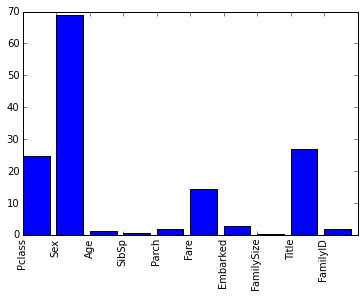

In [13]:
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyID"]

sel = SelectKBest(f_classif, k=5)
sel.fit(data[predictors], data['Survived'])
scores = -np.log10(sel.pvalues_)

plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [14]:
rf = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_leaf=4,min_samples_split=5)
scores_rf= cross_validation.cross_val_score(rf, data[predictors], data['Survived'])
scores_rf.mean()

NameError: name 'RandomForestClassifier' is not defined

Ensembling could give better results, choose diverse models with reasonable amount of same accuracies

In [36]:
predictors1 = ["Pclass", "Sex", "Age","Fare", "Embarked", "FamilySize", "Title", "FamilyID"]
predictors2 = ["Pclass", "Sex", "Age","Fare", "Embarked", "FamilySize", "Title","FamilyID"]
algorithms = [[RandomForestClassifier(n_estimators=100, random_state=1), predictors1],[LogisticRegression(random_state=1), predictors2]]

In [53]:
data[predictors1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 8 columns):
Pclass        891 non-null int64
Sex           891 non-null int64
Age           891 non-null float64
Fare          891 non-null float64
Embarked      891 non-null int64
FamilySize    891 non-null int64
Title         891 non-null int64
FamilyID      891 non-null int64
dtypes: float64(2), int64(6)
memory usage: 62.6 KB


In [15]:
data['Title'] = data.Title.astype(int)

In [63]:
import xgboost as xgb
#gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(data[predictors1], data['Survived'])
#predictions_xgb = gbm.predict(test_X)
kf = KFold(data.shape[0],n_folds=3,random_state=1)
predictions=[]
for train,test in kf:
    temp_predictions=[]
    gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(data[predictors1].iloc[train,:], data['Survived'].iloc[train])
    temp_predictions = gbm.predict(data[predictors1].iloc[test,:].astype(float))
    predictions.append(temp_predictions)


In [64]:
predictions = np.concatenate(predictions, axis=0)

In [65]:
accuracy_xgb = (data['Survived']==predictions).mean()
accuracy_xgb

0.82940516273849607

In [206]:
kf = KFold(data.shape[0],n_folds=3,random_state=1)
predictions=[]
for train, test in kf:
    train_target = data['Survived'].iloc[train]
    two_predictions=[]
    for alg in algorithms:
        model = alg[0]
        predictors = alg[1]
        model.fit(data[predictors].iloc[train,:], train_target)
        one_predictions=model.predict_proba(data[predictors].iloc[test,:].astype(float))[:,1]
        two_predictions.append(one_predictions)
    two_predictions = (two_predictions[0] + two_predictions[1])/2
    two_predictions[two_predictions<=0.5]=0
    two_predictions[two_predictions>0.5] = 1
    predictions.append(two_predictions)

predictions = np.concatenate(predictions, axis=0)

In [207]:
accuracy = (data['Survived']==predictions).mean()
accuracy

0.82603815937149272

Match the chnages on Test set

In [215]:
titanic = pd.read_csv('/Users/Sri/Desktop/Kaggle/Titanic/test.csv', index_col=None)

In [216]:
# replace missing values and convert categorical text to numerical
titanic['Fare'] = titanic['Fare'].fillna(titanic['Fare'].median())
titanic['Age'] = titanic['Age'].fillna(titanic['Age'].median())
titanic.loc[titanic['Sex']=='male', 'Sex'] = 0
titanic.loc[titanic['Sex']=='female', 'Sex'] = 1
# convert embarked column, first replace missing values
titanic['Embarked'] = titanic['Embarked'].fillna('S')
titanic.loc[titanic['Embarked']=='S','Embarked']=0
titanic.loc[titanic['Embarked']=='C','Embarked']=1
titanic.loc[titanic['Embarked']=='Q','Embarked']=2

In [217]:
titles = titanic['Name'].apply(get_title)
title_mappings = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mappings.items():
    titles[titles == k] = v
titanic["Title"] = titles

titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]

family_ids = titanic.apply(get_family_id, axis=1)
family_ids[titanic["FamilySize"] < 3] = -1
titanic["FamilyID"] = family_ids
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))


In [237]:
predictors1 = ["Pclass", "Sex", "Age","Fare", "Embarked", "FamilySize", "Title", "FamilyID"]
predictors2 = ["Pclass", "Sex", "Age","Fare", "Embarked", "FamilySize", "Title"]
algorithms = [[GradientBoostingClassifier(n_estimators=25, random_state=1, max_depth=3), predictors1],[LogisticRegression(random_state=1), predictors2]]

In [238]:
predictions_final=[]
for alg, predictors in algorithms:
    alg.fit(data[predictors], data['Survived'])
    predictions = alg.predict_proba(titanic[predictors].astype(float))[:,1]
    predictions_final.append(predictions)

predictions = (predictions_final[0] * 3 + predictions_final[1]) / 4
predictions[predictions<=0.5]=0
predictions[predictions>0.5] = 1

In [239]:
predictions = predictions.astype(int)

In [224]:
p = pd.read_csv('/Users/Sri/Downloads/gendermodel.csv',index_col=None)

In [240]:
submission = pd.DataFrame({'PassengerId':titanic['PassengerId'],'Survived':predictions})

In [241]:
submission.to_csv('/Users/Sri/Desktop/Kaggle/Titanic/titanic.csv', index=False)

NEW Approach

In [242]:
import numpy as np
import pandas as pd
from pandas import  DataFrame
from patsy import dmatrices
import string
from operator import itemgetter
#json library for settings file
import json
# import the machine learning library that holds the randomforest
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import classification_report
#joblib library for serialization
from sklearn.externals import joblib

In [243]:
l = pd.read_csv('/Users/Sri/Desktop/Kaggle/Titanic/titanic.csv', index_col=None)

l[l.Survived!=l.NEW]

Graphically study the Data

In [246]:
t = pd.read_csv('/Users/Sri/Desktop/Kaggle/Titanic/train.csv', index_col=None)

In [248]:
t.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


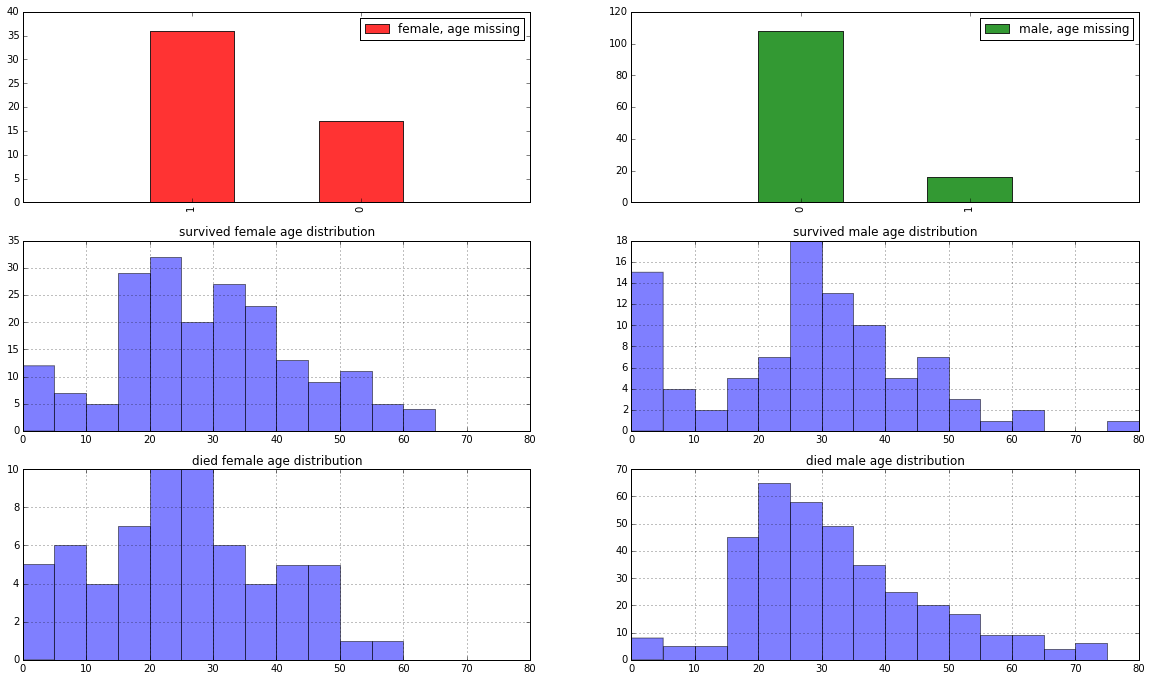

In [319]:
fig= plt.figure(figsize=(20,6), dpi=1600)
ax1 = fig.add_subplot(3,2,1)
female = t.Survived[t['Sex']=='female'] [t['Age'].isnull()].value_counts()
female.plot(kind='bar',label='female, age missing', color='red', alpha=0.8)
ax1.set_xlim(-1, len(female))
plt.legend(loc='best')

ax2 = fig.add_subplot(322)
male = t.Survived[t['Sex']=='male'][t['Age'].isnull()].value_counts()
male.plot(kind='bar', label='male, age missing', color='green', alpha=0.8)
ax2.set_xlim(-1, len(male))
plt.legend(loc='best')

ax3 = fig.add_subplot(3,2,3)
t.Age[t.Survived==1][t.Sex=='female'].dropna().hist(bins=16,range=(0,80),alpha=0.5)
ax3.set_title('survived female age distribution')

ax4 = fig.add_subplot(324)
t.Age[t.Survived==1][t.Sex=='male'].dropna().hist(bins=16,range=(0,80),alpha=0.5)
ax4.set_title('survived male age distribution')
fig.subplots_adjust(bottom=-0.5, top=1) # for adjusting title positions

ax5 = fig.add_subplot(325)
t.Age[t.Survived==0][t.Sex=='female'].dropna().hist(bins=16,range=(0,80),alpha=0.5)
ax5.set_title('died female age distribution')

ax6 = fig.add_subplot(326)
t.Age[t.Survived==0][t.Sex=='male'].dropna().hist(bins=16,range=(0,80),alpha=0.5)
ax6.set_title('died male age distribution')

plt.show()

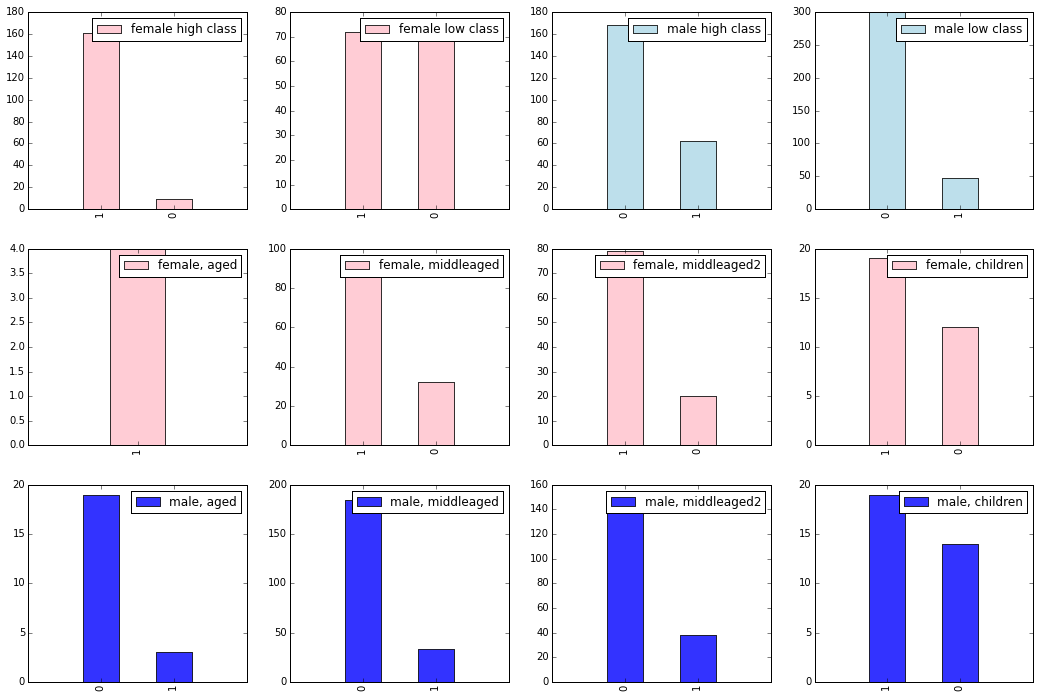

In [327]:
fig = plt.figure(figsize=(18,12), dpi= 1600)
ax3= fig.add_subplot(341)
female_highclass = t.Survived[t.Sex=='female'][t.Pclass!=3].value_counts()
female_highclass.plot(kind='bar', label='female high class',color='pink', alpha=0.8)
ax3.set_xlim(-1, len(female_highclass))
plt.legend(loc='best')

ax4= fig.add_subplot(342)
female_lowclass = t.Survived[t.Sex=='female'][t.Pclass==3].value_counts()
female_lowclass.plot(kind='bar', label='female low class',color='pink', alpha=0.8)
ax4.set_xlim(-1, len(female_lowclass))
plt.legend(loc='best')

ax5= fig.add_subplot(343)
male_highclass = t.Survived[t.Sex=='male'][t.Pclass!=3].value_counts()
male_highclass.plot(kind='bar', label='male high class',color='lightblue', alpha=0.8)
ax5.set_xlim(-1, len(male_highclass))
plt.legend(loc='best')

ax6= fig.add_subplot(344)
male_lowclass = t.Survived[t.Sex=='male'][t.Pclass==3].value_counts()
male_lowclass.plot(kind='bar', label='male low class',color='lightblue', alpha=0.8)
ax6.set_xlim(-1, len(male_lowclass))
plt.legend(loc='best')

ax7 = fig.add_subplot(345)
female_aged = t.Survived[t.Sex=='female'][t.Age>=60].value_counts()
female_aged.plot(kind='bar', label='female, aged', color='pink', alpha=0.8)
ax7.set_xlim(-1, len(female_aged))
plt.legend(loc='best')

ax8 = fig.add_subplot(346)
female_middleaged = t.Survived[t.Sex=='female'][t.Age>10][t.Age<=30].value_counts()
female_middleaged.plot(kind='bar', label='female, middleaged', color='pink', alpha=0.8)
ax8.set_xlim(-1, len(female_middleaged))
plt.legend(loc='best')

ax9 = fig.add_subplot(347)
female_middleaged2 = t.Survived[t.Sex=='female'][t.Age>30][t.Age<60].value_counts()
female_middleaged2.plot(kind='bar', label='female, middleaged2', color='pink', alpha=0.8)
ax9.set_xlim(-1, len(female_middleaged2))
plt.legend(loc='best')

ax10 = fig.add_subplot(348)
female_child = t.Survived[t.Sex=='female'][t.Age<=10].value_counts()
female_child.plot(kind='bar', label='female, children', color='pink', alpha=0.8)
ax10.set_xlim(-1, len(female_child))
plt.legend(loc='best')

#male

ax11 = fig.add_subplot(349)
male_aged = t.Survived[t.Sex=='male'][t.Age>=60].value_counts()
male_aged.plot(kind='bar', label='male, aged', color='blue', alpha=0.8)
ax11.set_xlim(-1, len(male_aged))
plt.legend(loc='best')

ax12 = fig.add_subplot(3,4,10)
male_middleaged = t.Survived[t.Sex=='male'][t.Age>10][t.Age<=30].value_counts()
male_middleaged.plot(kind='bar', label='male, middleaged', color='blue', alpha=0.8)
ax12.set_xlim(-1, len(male_middleaged))
plt.legend(loc='best')

ax13 = fig.add_subplot(3,4,11)
male_middleaged2 = t.Survived[t.Sex=='male'][t.Age>30][t.Age<60].value_counts()
male_middleaged2.plot(kind='bar', label='male, middleaged2', color='blue', alpha=0.8)
ax13.set_xlim(-1, len(male_middleaged2))
plt.legend(loc='best')

ax14 = fig.add_subplot(3,4,12)
male_child = t.Survived[t.Sex=='male'][t.Age<=10].value_counts()
male_child.plot(kind='bar', label='male, children', color='blue', alpha=0.8)
ax14.set_xlim(-1, len(male_child))
plt.legend(loc='best')

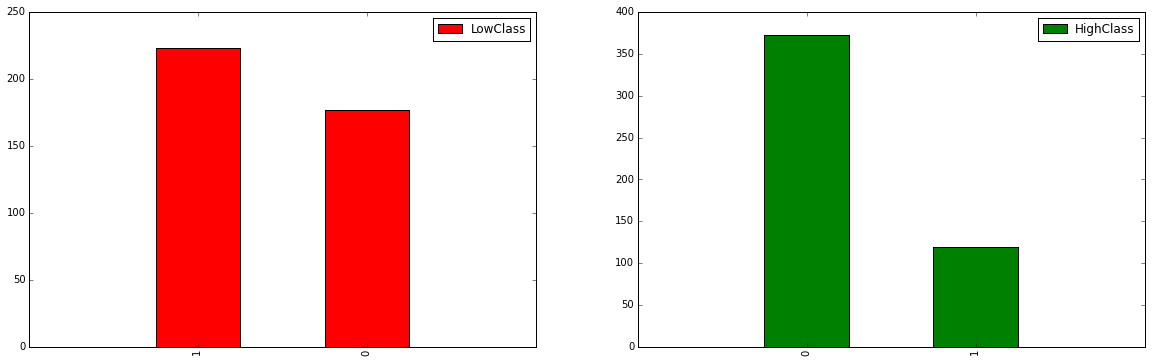

In [328]:
fig = plt.figure(figsize=(20,6), dpi = 1600)
ax1 = fig.add_subplot(121)
lowclass = t.Survived[t.Pclass!=3].value_counts()
lowclass.plot(kind='bar', label='LowClass', color='red')
ax1.set_xlim(-1,2)
plt.legend(loc='best')

ax2 = fig.add_subplot(122)
highclass = t.Survived[t.Pclass==3].value_counts()
highclass.plot(kind='bar', label='HighClass', color='green')
ax2.set_xlim(-1,2)
plt.legend(loc='best')


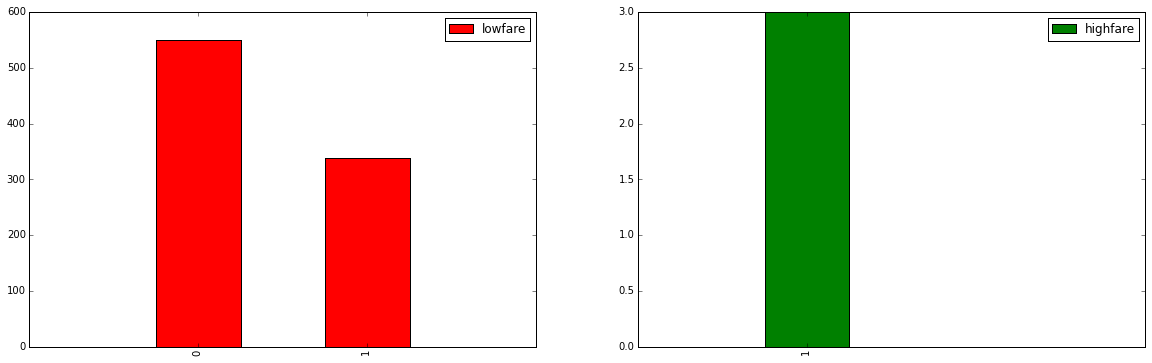

In [329]:
fig = plt.figure(figsize=(20,6), dpi = 1600)
ax1 = fig.add_subplot(121)
lowfare = t.Survived[t.Fare<=300].value_counts()
lowfare.plot(kind='bar', label='lowfare', color='red')
ax1.set_xlim(-1,2)
plt.legend(loc='best')


ax2 = fig.add_subplot(122)
highfare = t.Survived[t.Fare>300].value_counts()
highfare.plot(kind='bar', label='highfare', color='green')
ax2.set_xlim(-1,2)
plt.legend(loc='best')


In [344]:
for i in range(1,4):
    print('Male: {0} {1}'.format(i,len(t[(t.Sex=='male') & (t.Pclass==i)])))
    print('FeMale:{0} {1}'.format(i, len(t[(t.Sex=='female') & (t.Pclass==i)])))

Male: 1 122
FeMale:1 94
Male: 2 108
FeMale:2 76
Male: 3 347
FeMale:3 144


In [332]:
len(t[(t.Sex=='male') & (t.Pclass==1)])

122

In [67]:
from sklearn.cross_validation import StratifiedKFold

In [68]:
kf = StratifiedKFold(data['Survived'], n_folds=3, random_state=1)

In [82]:
for i, j in kf:
    print((data['Survived'].iloc[j]==1).sum())
    print((data['Survived'].iloc[j]==0).sum())

114
183
114
183
114
183


In [16]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,NameLength,Title,FamilyID
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,NaN,0,1,23,1,-1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,1,1,51,3,-1
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,NaN,0,0,22,2,-1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,C123,0,1,44,3,-1
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,NaN,0,0,24,1,-1


In [2]:
r1 = pd.read_csv('/Users/Sri/Downloads/rfv3cn3 (1).csv', index_col=None)

In [5]:
r2.head()

,Id,Expected
0,1,0.508
1,2,1.016
2,3,2.540
3,4,4.826
4,5,1.524


In [4]:
r2 = pd.read_csv('/Users/Sri/Downloads/dl_mp.csv', index_col=None)

In [8]:
x = ((r1.Expected * 2) + (r2.Expected * 1) ) / 3

In [17]:
r1['Expected'] = x

In [36]:
r1.to_csv('/Users/Sri/Desktop/howmuchrainII.csv', index=False,index_col=None)

In [37]:
r1 = pd.read_csv('/Users/Sri/Desktop/howmuchrainII.csv', index_col=None)

In [31]:
r1.drop('Unnamed: 0', inplace=True, axis=1)

In [38]:
r1

,Id,Expected
0,1,0.677333
1,2,1.016000
2,3,2.201333
3,4,4.487333
4,5,2.540000
5,6,1.016000
6,7,2.878667
7,8,2.032000
8,9,1.100667
9,10,5.588000
